In [1]:
# Environment needed
#conda activate scvi_env

from scvi.module.base import BaseModuleClass, LossRecorder, auto_move_data
#from svae import SpikeSlabVAE, metrics, sparse_shift, sVAE
from typing import Optional, Iterable, Callable, Literal
from torch.distributions import kl_divergence as kl
from scvi.distributions import NegativeBinomial
from typing import List, Optional, Sequence
from scvi.nn import DecoderSCVI, Encoder
from scvi.utils import setup_anndata_dsp
from scipy.stats import chi2_contingency
from torch.distributions import Normal
from svae._utils import GumbelSigmoid
from scvi.data import AnnDataManager
#from matplotlib_venn import venn3
from scvi._compat import Literal
import matplotlib.pyplot as plt
from scvi import REGISTRY_KEYS
from scvi.data.fields import (
    CategoricalJointObsField,
    CategoricalObsField,
    LayerField,
    NumericalJointObsField,
    NumericalObsField,
)
from scvi.model.base import (
    ArchesMixin,
    BaseModelClass,
    RNASeqMixin,
    UnsupervisedTrainingMixin,
    VAEMixin,
)
from anndata import AnnData
from torch import logsumexp
import scrublet as scr
import cellrank as cr
import seaborn as sns
import scvelo as scv
import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib
import argparse
import logging
import anndata
import torch
import scvi
import h5py
import umap


# Setting the seed
np.random.seed(42)

%load_ext autoreload

# helpful for development mode when modules are being changed
%autoreload 2


Global seed set to 0
/Users/brendamelano/miniconda3/envs/scvi_env/lib/python3.11/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/Users/brendamelano/miniconda3/envs/scvi_env/lib/python3.11/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [ ]:
# Still need to install
from typing import Callable, Iterable, Optional
from scvi import REGISTRY_KEYS
from typing import Literal
import torchmetrics
import networkx
import network
import fsspec
import desc 
import svae
import os

In [2]:
# Loading Replogle data
adata = scv.read("replogle.h5ad")


# Making the variable names unique
adata.var_names_make_unique()


# Creating a chem column with the names of genes that were perturbed
adata.obs["chem"] = adata.obs["gene"]


# Creating pathway sets
EXOSOME = ["ZC3H3", "ZFC3H1", "CAMTA2", "DHX29", "DIS3", "EXOSC1", "EXOSC2", "EXOSC3", "EXOSC4", "EXOSC5", "EXOSC6", "EXOSC7", "EXOSC8", "EXOSC9", "MBNL1", "PABPN1", "PIBF1", "MTREX", "ST20-MTHFS", "THAP2"]

SPLICEOSOME = ["ZMAT2", "CLNS1A", "DDX20", "DDX41", "DDX46", "ECD", "GEMIN4", "GEMIN5", "GEMIN6", "GEMIN8", "INTS3", "INTS4", "INTS9", "ICE1", "LSM2", "LSM3", "LSM5", "LSM5", "LSM6", "LSM7", "MMP17", "PHAX", "PRPF4", "PRPF6", "SART3", "SF3A2", "SMN2", "SNAPC1", "SNAPC3", "SNRPD3", "SNRPG", "TIPARP", "TTC27", "TXNL4A", "USPL1"]

MEDIATOR_COMPLEX = ["ZDHHC7", "ADAM10", "EPS8L1", "FAM136A", "POGLUT3", "MED10", "MED11", "MED12", "MED14", "MED17", "MED18", "MED19", "MED1", "MED20", "MED21", "MED22", "MED28", "MED29", "MED30", "MED6", "MED7", "MED8", "MED9", "SUPT6H", "BRIX1", "TMX2"]

NUCLEOTIDE_EXCISION_REPAIR = ["C1QBP", "CCNH", "ERCC2", "ERCC3", "GPN1", "GPN3", "GTF2E1", "GTF2E2", "GTF2H1", "GTF2H4", "MNAT1", "NUMA1", "PDRG1", "PFDN2", "POLR2B", "POLR2F", "POLR2G", "RPAP1", "RPAP2", "RPAP3", "TANGO6", "TMEM161B", "UXT"]

S40_RIBOSOMAL_UNIT = ["ZCCHC9", "ZNF236", "C1orf131", "ZNF84", "ZNHIT6", "CCDC59", "AATF", "CPEB1", "DDX10", "DDX18", "DDX21", "DDX47", "DDX52", "DHX33", "DHX37", "DIMT1", "DKC1", "DNTTIP2", "ESF1", "FBL", "FBXL14", "FCF1", "GLB1", "HOXA3", "IMP4", "IMPA2", "KRI1", "KRR1", "LTV1", "MPHOSPH10", "MRM1", "NAF1", "NOB1", "NOC4L", "NOL6", "NOP10", "PDCD11", "ABT1", "PNO1", "POP1", "POP4", "POP5", "PSMG4", "PWP2", "RCL1", "RIOK1", "RIOK2", "RNF31", "RPP14", "RPP30", "RPP40", "RPS10-NUDT3", "RPS10", "RPS11", "RPS12", "RPS13", "RPS15A", "RPS18", "RPS19BP1", "RPS19", "RPS21", "RPS23", "RPS24", "RPS27A", "RPS27", "RPS28", "RPS29", "RPS2", "RPS3A", "RPS3", "RPS4X", "RPS5", "RPS6", "RPS7", "RPS9", "RPSA", "RRP12", "RRP7A", "RRP9", "SDR39U1", "SRFBP1", "TBL3", "TRMT112", "TSR1", "TSR2", "BYSL", "C12orf45", "USP36", "UTP11", "UTP20", "UTP23", "UTP6", "BUD23", "WDR36", "WDR3", "WDR46", "AAR2"]

S39_RIBOSOMAL_UNIT = ["AARS2", "DHX30", "GFM1", "HMGB3", "MALSU1", "MRPL10", "MRPL11", "MRPL13", "MRPL14", "MRPL16", "MRPL17", "MRPL18", "MRPL19", "MRPL22", "MRPL23", "MRPL24", "MRPL27", "MRPL2", "MRPL33", "MRPL35", "MRPL36", "MRPL37", "MRPL38", "MRPL39", "MRPL3", "MRPL41", "MRPL42", "MRPL43", "MRPL44", "MRPL4", "MRPL50", "MRPL51", "MRPL53", "MRPL55", "MRPL9", "MRPS18A", "MRPS30", "NARS2", "PTCD1", "RPUSD4", "TARS2", "VARS2", "YARS2"]

S60_RIBOSOMAL_UNIT = ["CARF", "CCDC86", "DDX24", "DDX51", "DDX56", "EIF6", "ABCF1", "GNL2", "LSG1", "MAK16", "MDN1", "MYBBP1A", "NIP7", "NLE1", "NOL8", "NOP16", "NVL", "PES1", "PPAN", "RBM28", "RPL10A", "RPL10", "RPL11", "RPL13", "RPL14", "RPL17", "RPL19", "RPL21", "RPL23A", "RPL23", "RPL24", "RPL26", "RPL27A", "RPL30", "RPL31", "RPL32", "RPL34", "RPL36", "RPL37A", "RPL37", "RPL38", "RPL4", "RPL5", "RPL6", "RPL7", "RPL8", "RPL9", "RRS1", "RSL1D1", "SDAD1", "BOP1", "TEX10", "WDR12"]

MT_PROTEIN_TRANSLOCATION = ["AARS", "CHCHD4", "DNAJA3", "DNAJC19", "EIF2B1", "EIF2B2", "EIF2B3", "EIF2B4", "EIF2B5", "FARSA", "FARSB", "GFER", "GRPEL1", "HARS", "HSPA9", "HSPD1", "HSPE1", "IARS2", "LARS", "LETM1", "NARS", "OXA1L", "PGS1", "PHB2", "PHB", "PMPCA", "PMPCB", "ATP5F1A", "ATP5F1B", "ATP5PD", "QARS", "RARS", "SAMM50", "PRELID3B", "TARS", "TIMM23B", "TIMM44", "TOMM22", "TTC1", "VARS"]


# Creating an empty list for the pathway names
pathway_samples = []


# Making a list of all the pathway names
pathway_list = [
    EXOSOME,
    SPLICEOSOME,
    MEDIATOR_COMPLEX,
    NUCLEOTIDE_EXCISION_REPAIR,
    S40_RIBOSOMAL_UNIT,
    S39_RIBOSOMAL_UNIT,
    S60_RIBOSOMAL_UNIT,
    MT_PROTEIN_TRANSLOCATION,
]


# Defining pathway names
pathway_names = [
    "EXOSOME",
    "SPLICEOSOME",
    "MEDIATOR_COMPLEX",
    "NUCLEOTIDE_EXCISION_REPAIR",
    "S40_RIBOSOMAL_UNIT",
    "S39_RIBOSOMAL_UNIT",
    "S60_RIBOSOMAL_UNIT",
    "MT_PROTEIN_TRANSLOCATION",
]


# Looping through every perturbation in the pert column
for perturb in adata.obs["gene"]:

    # setting a default matched variable to false
    matched = False
    for pathway_id, pathway_ in enumerate(pathway_list):
        if perturb in pathway_:
            pathway_samples += [pathway_names[pathway_id]]
            matched = True
    if not matched:
        pathway_samples += ["OTHER"]


split = "SPLICEOSOME"


# Preset split to splicosome up above
if split == "effect":
    
    # get some form of energy distance using MMD
    def mmd_linear(X, Y):
        XX = np.dot(X, X.T)
        YY = np.dot(Y, Y.T)
        XY = np.dot(X, Y.T)
        return XX.mean() + YY.mean() - 2 * XY.mean()

    res_energy = {}
    for guide in adata.obs["guide_ids"].unique():
        index_control = np.where(adata.obs["guide_ids"] == "")[0][:1000]
        index_condition = np.where(adata.obs["guide_ids"] == guide)[0][:1000]
        res_energy[guide] = mmd_linear(
            adata.obsm["X_pca"][index_control], adata.obsm["X_pca"][index_condition]
        )

    series = pd.Series(res_energy)
    hold_out_guides = series.sort_values(ascending=False)[:30].index


elif split in pathway_names:
    hold_out_guides = pathway_list[
        np.where(np.array(pathway_names) == split)[0][0]
    ]
    # convert format


# Splitting between train and test set
#adata_train = adata[[x not in hold_out_guides for x in adata.obs["chem"]]].copy()
#adata_test = adata[[x in hold_out_guides for x in adata.obs["chem"]]].copy()



In [6]:
# Defining the sparse penalty
# What does this value mean?
sparse_penalty = 1


# Setting the anndata object
SpikeSlabVAE.setup_anndata(adata, 
                           labels_key = 'gene') # label_key is essential for isolating the perturbation per latent variable df


# Setting up the model
model = SpikeSlabVAE(adata, 
                     n_latent=6, 
                     n_layers=4)


# Defining a list of all the perturbations within the df
# Where is this used?
guide_list = adata.obs["chem"].values



['DHX33', 'UPF2', 'GPS1', 'INO80B', 'LTV1', ..., 'OGFOD1', 'ZNHIT6', 'CPSF3', 'MED30', 'HEATR1']
Length: 116641
Categories (681, object): ['AAR2', 'AARS', 'AARS2', 'AATF', ..., 'ZNF236', 'ZNF560', 'ZNHIT1', 'ZNHIT6']

In [10]:
# Choose 10 random targets to be in test dataset

# Throws error when I run this
#test_range = range(80, 100)
#adata_train = adata[[x not in test_range for x in adata.obs["chem"]]].copy()
#adata_test = adata[[x in test_range for x in adata.obs["chem"]]].copy()



chem_prior = (
    args.method == "sVAE" or args.method == "iVAE" or args.method == "SpikeSlabVAE"
)

In [7]:
#model.adata = adata_train


# better understand these parameters
model.module.beta = 1


# Setting the sparse mask penalty value
model.module.sparse_mask_penalty = 0.1


# Training the model
model.train(
        max_epochs=50,
        check_val_every_n_epoch=1,
        early_stopping=True,
        plan_kwargs={
            "n_epochs_kl_warmup": 10,
        }#,
        #logger=wandb_logger,
    )

# Get the label key from the state registry
label_key = model.adata_manager.get_state_registry(REGISTRY_KEYS.LABELS_KEY)["original_key"]


# Get the categorical mapping for the labels
perturbation_mapping = model.adata_manager.get_state_registry(REGISTRY_KEYS.LABELS_KEY)["categorical_mapping"]


# Convert action_prior_mean to a numpy array
action_prior_mean = model.module.action_prior_mean.detach().numpy()


# Saving a df that reperesents how each perturbation affects latent variables
action_prior_df = pd.DataFrame(action_prior_mean, index=perturbation_mapping, columns=[f"Latent_{i}" for i in range(model.module.
                                                                                                                    n_latent)])

# Export the DataFrame to a CSV file
#action_df.to_csv('/Users/brendamelano/Desktop/RL_for_reprogramming/action_df.csv', index=False)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/brendamelano/miniconda3/envs/scvi_env/lib/python3.11/site-packages/pytorch_lightning/trainer/trainer.py:1788: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 50/50: 100%|█████████████████████████████████████████████████████████| 50/50 [06:49<00:00,  7.75s/it, loss=1.9e+08, v_num=1]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 50/50: 100%|█████████████████████████████████████████████████████████| 50/50 [06:49<00:00,  8.19s/it, loss=1.9e+08, v_num=1]


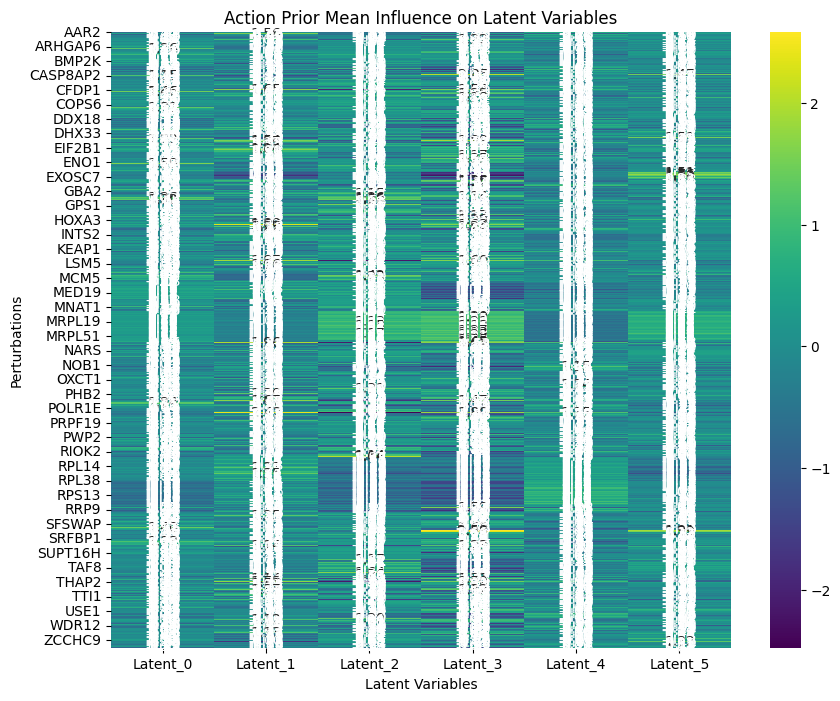

In [13]:
# Plot a heatmap of the action prior means
plt.figure(figsize=(5, 4))
sns.heatmap(action_prior_df, cmap="viridis", annot=True, fmt=".2f")
plt.title("Action Prior Mean Influence on Latent Variables")
plt.xlabel("Latent Variables")
plt.ylabel("Perturbations")
plt.show()

In [16]:
# Filtering genes based on minimum counts 
#scv.pp.filter_genes(adata, min_shared_counts=20)


# Normalizing the cells by all counts across all the genes
scv.pp.normalize_per_cell(adata)
#sc.pp.normalize_total(adata, target_sum=1e4)


# Filtering the dataset to only keep the most variable genes
# this is redundant to selecting highly variable genes
scv.pp.filter_genes_dispersion(adata, n_top_genes=1500)


# Log transformation
scv.pp.log1p(adata)


# Preserving the counts
adata.layers["counts"] = adata.X.copy() 


# Freezing the data in raw
# try moving to after selecting highly variable genes
adata.raw = adata


Skip filtering by dispersion since number of variables are less than `n_top_genes`.


/var/folders/qb/gs_p7v5x2yd351t93zbgj8gr0000gn/T/ipykernel_77602/333454649.py:16: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  scv.pp.log1p(adata)


In [ ]:
# Creating a df with the indexes (CellIDs from the adata object)
sample_one_index = pd.DataFrame(adata.obs.index)


# Selecting highly variable genes
# Research all the possible parameters for this
#sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=3000, 
    subset=True,
    layer="counts"
)


# Making a variable for the genes names
genes = adata.var.index.values


# Make sure this shouldn't come after the scale
cell_cycle_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/scvi/regev_lab_cell_cycle_genes.txt')]


# Split into s and g2m gene lists
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]


# Saving object for cell cycle genes based on those in adata
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]


# Scoring the cell cycle
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)


# Computing the ccdifference score
adata.obs['ccdifference'] = adata.obs['S_score'] - adata.obs['G2M_score']

In [14]:

adata = adata[:, adata.var.highly_variable]


AttributeError: 'DataFrame' object has no attribute 'highly_variable'

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


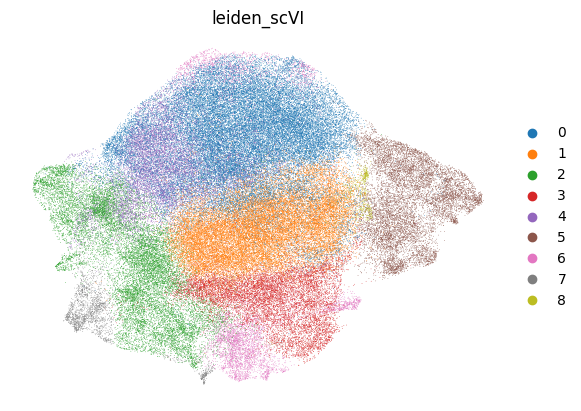

In [9]:
# Getting the latent representation
latent = model.get_latent_representation()


# adding the latent variables to the adata object
adata.obsm["X_scVI"] = latent


# using the latent space for umap generation
sc.pp.neighbors(adata, use_rep="X_scVI")


# computing umap
sc.tl.umap(adata, min_dist=0.3)


# clustering using the leiden algorithm
sc.tl.leiden(adata, key_added="leiden_scVI", resolution=0.3)


# Plotting the clusters
sc.pl.umap(
    adata,
    color=["leiden_scVI"],
    frameon=False,
)

/Users/brendamelano/miniconda3/envs/scvi_env/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:657: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


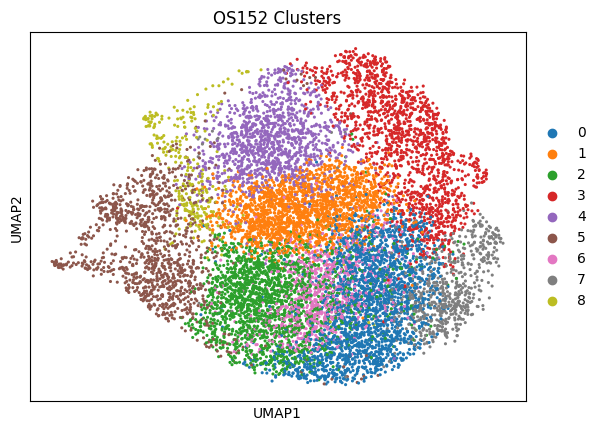

In [17]:


# Regressing out total couts, mitochondrial percentage and ccdifference scores
#sc.pp.regress_out(adata, ['n_counts']) #, 'ccdifference', 'pct_counts_mt'
            

# DGEA Analysis

In [10]:
# Extract gene_id and gene_name from adata.var
gene_mapping = adata.var[['gene_name']].reset_index()
gene_mapping.columns = ['ENSG_ID', 'gene_name']

# Set 'gene_name' as the index
adata.var.set_index('gene_name', inplace=True)

# Drop the old index (ENSG_ID) if not needed
#adata.var.drop(columns=['gene_id'], inplace=True)


In [26]:
print(adata.var.head())

            chr    start      end           class strand  length  in_matrix  \
gene_name                                                                     
NOC2L      chr1   944203   959309  gene_version11      -   15106       True   
ISG15      chr1  1001138  1014540  gene_version10      +   13402       True   
AURKAIP1   chr1  1373730  1375495  gene_version13      -    1765       True   
ATAD3A     chr1  1512162  1534685  gene_version14      +   22523       True   
RPL22      chr1  6185020  6209389  gene_version11      -   24369       True   

                mean        std        cv      fano  
gene_name                                            
NOC2L       1.415674   1.397208  0.986957  1.378984  
ISG15       0.334181   0.675689  2.021921  1.366189  
AURKAIP1    5.133884   3.535071  0.688576  2.434166  
ATAD3A      0.909780   1.099277  1.208289  1.328243  
RPL22      17.991259  10.090179  0.560838  5.658955  


In [28]:
# Filtering genes based on minimum counts 
#scv.pp.filter_genes(adata, min_shared_counts=20)


# Normalizing the cells by all counts across all the genes
scv.pp.normalize_per_cell(adata)
#sc.pp.normalize_total(adata, target_sum=1e4)


# Filtering the dataset to only keep the most variable genes
# this is redundant to selecting highly variable genes
scv.pp.filter_genes_dispersion(adata, n_top_genes=1500)


# Log transformation
scv.pp.log1p(adata)


# Preserving the counts
adata.layers["counts"] = adata.X.copy() 


# Freezing the data in raw
# try moving to after selecting highly variable genes
adata.raw = adata

# Performing DGEA between clusters
sc.tl.rank_genes_groups(adata, 'leiden_scVI', method='wilcoxon')

# Creating a df for the cluster-specific markers
cluster_markers = pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(60)
print(cluster_markers)

# Check if any of the clusters contain 'Prrt4' as a marker
is_prrt4_marker = cluster_markers.apply(lambda col: col.isin(['Pgk1-rs7'])).any()#'Prrt4',

# Print the clusters containing 'Prrt4' as a marker
print(f"Clusters containing 'Prrt4' as a marker: {is_prrt4_marker[is_prrt4_marker].index.tolist()}")

Normalized count data: X.
Skip filtering by dispersion since number of variables are less than `n_top_genes`.


/var/folders/qb/gs_p7v5x2yd351t93zbgj8gr0000gn/T/ipykernel_87478/830051475.py:16: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  scv.pp.log1p(adata)


In [13]:
# Creating a df for the cluster specific markers
cluster_markers = pd.DataFrame(adata.uns['rank_genes_groups']['gene_name']).head(60)

KeyError: 'gene_name'

# Identifying the epicenter coordinates for all clusters 
## First isolating the coordinates for each cell

In [18]:
# Computing mean of latent variables for all cells in 2 clusters
# these will be used as points for reprogramming tries
# Will use terminal states in the future

# Creating an object to save all of the PCA coordinates
pca_coords = adata.obsm['X_pca']


# Creating a df of the PCA coordinates
pca_df = pd.DataFrame(pca_coords, index=adata.obs_names)


#  
pca_df.columns = [f'PC{i+1}' for i in range(pca_df.shape[1])]


# Creating a leiden cluster column in the new df
pca_df['leiden'] = adata.obs['leiden'].values


#
mean_pca_per_cluster = pca_df.groupby('leiden').mean()

mean_pca_per_cluster_array = mean_pca_per_cluster.values

In [21]:
cluster_id = '5'

mean_values_for_cluster_5 = mean_pca_per_cluster.loc[cluster_id].values

mean_values_for_cluster_5

cluster_id = '7'

mean_values_for_cluster_7 = mean_pca_per_cluster.loc[cluster_id].values

mean_values_for_cluster_7

array([-3.23593378e+00,  7.33371162e+00,  1.81010270e+00, -9.48642194e-01,
       -1.55114865e+00, -1.33030069e+00, -1.67945540e+00,  1.99586451e-01,
        3.81879583e-02,  8.58926058e-01,  7.34219491e-01,  1.52005672e-01,
        1.70716122e-01, -1.42699741e-02,  5.51014066e-01,  2.44627759e-01,
       -2.30113901e-02,  2.63603419e-01,  2.70984590e-01, -9.00576487e-02,
       -9.17504951e-02, -6.03279173e-02, -5.32786436e-02, -1.54042309e-02,
       -1.83029529e-02,  1.90059572e-01,  2.18731016e-01,  8.98585480e-04,
        4.87928316e-02,  2.13394091e-02,  2.14961115e-02,  3.06398481e-01,
        7.02026859e-02, -9.78142470e-02,  1.23606093e-01,  1.33257464e-01,
        5.33651235e-03, -3.72556373e-02, -1.07898824e-01, -1.71902806e-01,
        9.14371293e-03,  5.32880016e-02, -7.07355738e-02,  1.50770485e-01,
       -1.63944215e-01, -5.81714213e-02, -1.06519848e-01, -8.10784027e-02,
       -2.02985983e-02, -2.29750155e-03], dtype=float32)

In [7]:
def reinit_model(model):
    # create new model and copy module inside of it
    # this will create a new trainer etc..
    temp_module = model.module
    model_ = model.__class__(adata, n_latent=5, n_layers=6)
    model_.module = temp_module
    return model_


model = reinit_model(model)
model.module.freeze_params()
model.adata = adata

In [18]:
test_range = [
        np.where(x == guide_list)[0][0] for x in adata.obs["chem"].unique()
    ]

In [10]:
model.module.reinit_actsparse_and_freeze(test_range)

NameError: name 'test_range' is not defined

In [5]:
class SpikeSlabVAE(
    RNASeqMixin, VAEMixin, ArchesMixin, UnsupervisedTrainingMixin, BaseModelClass
):
    """
    single-cell Variational Inference [Lopez18]_.

    Parameters
    ----------
    adata
        AnnData object that has been registered via :meth:`~scvi.model.SCVI.setup_anndata`.
    n_hidden
        Number of nodes per hidden layer.
    n_latent
        Dimensionality of the latent space.
    n_layers
        Number of hidden layers used for encoder and decoder NNs.
    dropout_rate
        Dropout rate for neural networks.
    dispersion
        One of the following:

        * ``'gene'`` - dispersion parameter of NB is constant per gene across cells
        * ``'gene-batch'`` - dispersion can differ between different batches
        * ``'gene-label'`` - dispersion can differ between different labels
        * ``'gene-cell'`` - dispersion can differ for every gene in every cell
    gene_likelihood
        One of:

        * ``'nb'`` - Negative binomial distribution
        * ``'zinb'`` - Zero-inflated negative binomial distribution
        * ``'poisson'`` - Poisson distribution
    latent_distribution
        One of:

        * ``'normal'`` - Normal distribution
        * ``'ln'`` - Logistic normal distribution (Normal(0, I) transformed by softmax)
    **model_kwargs
        Keyword args for :class:`~scvi.module.VAE`

    Examples
    --------
    >>> adata = anndata.read_h5ad(path_to_anndata)
    >>> scvi.model.SCVI.setup_anndata(adata, batch_key="batch")
    >>> vae = scvi.model.SCVI(adata)
    >>> vae.train()
    >>> adata.obsm["X_scVI"] = vae.get_latent_representation()
    >>> adata.obsm["X_normalized_scVI"] = vae.get_normalized_expression()

    Notes
    -----
    See further usage examples in the following tutorials:

    1. :doc:`/tutorials/notebooks/api_overview`
    2. :doc:`/tutorials/notebooks/harmonization`
    3. :doc:`/tutorials/notebooks/scarches_scvi_tools`
    4. :doc:`/tutorials/notebooks/scvi_in_R`
    """

    def __init__(
        self,
        adata: AnnData,
        n_hidden: int = 128,
        n_latent: int = 10,
        n_layers: int = 1,
        dropout_rate: float = 0.1,
        latent_distribution: Literal["normal", "ln"] = "normal",
        **module_kwargs,
    ):
        super().__init__(adata)

        n_cats_per_cov = (
            self.adata_manager.get_state_registry(
                REGISTRY_KEYS.CAT_COVS_KEY
            ).n_cats_per_key
            if REGISTRY_KEYS.CAT_COVS_KEY in self.adata_manager.data_registry
            else None
        )
        n_batch = self.summary_stats.n_batch

        self.module = SpikeSlabVAEModule(
            n_input=self.summary_stats.n_vars,
            n_batch=n_batch,
            n_labels= self.summary_stats.n_labels,
            n_continuous_cov=self.summary_stats.get("n_extra_continuous_covs", 0),
            n_cats_per_cov=n_cats_per_cov,
            n_hidden=n_hidden,
            n_latent=n_latent,
            n_layers=n_layers,
            dropout_rate=dropout_rate,
            latent_distribution=latent_distribution,
            **module_kwargs,
        )
        self._model_summary_string = (
            "SpikeSlabVAE Model with the following params: \nn_hidden: {}, n_latent: {}, n_layers: {}, dropout_rate: "
            "{}, latent_distribution: {}"
        ).format(
            n_hidden,
            n_latent,
            n_layers,
            dropout_rate,
            latent_distribution,
        )
        self.init_params_ = self._get_init_params(locals())

    @classmethod
    @setup_anndata_dsp.dedent
    def setup_anndata(
        cls,
        adata: AnnData,
        layer: Optional[str] = None,
        batch_key: Optional[str] = None,
        labels_key: Optional[str] = None,
        size_factor_key: Optional[str] = None,
        categorical_covariate_keys: Optional[List[str]] = None,
        continuous_covariate_keys: Optional[List[str]] = None,
        **kwargs,
    ):
        """
        %(summary)s.

        Parameters
        ----------
        %(param_layer)s
        %(param_batch_key)s
        %(param_labels_key)s
        %(param_size_factor_key)s
        %(param_cat_cov_keys)s
        %(param_cont_cov_keys)s
        """
        setup_method_args = cls._get_setup_method_args(**locals())
        anndata_fields = [
            LayerField(REGISTRY_KEYS.X_KEY, layer, is_count_data=True),
            CategoricalObsField(REGISTRY_KEYS.BATCH_KEY, batch_key),
            CategoricalObsField(REGISTRY_KEYS.LABELS_KEY, labels_key),
            NumericalObsField(
                REGISTRY_KEYS.SIZE_FACTOR_KEY, size_factor_key, required=False
            ),
            CategoricalJointObsField(
                REGISTRY_KEYS.CAT_COVS_KEY, categorical_covariate_keys
            ),
            NumericalJointObsField(
                REGISTRY_KEYS.CONT_COVS_KEY, continuous_covariate_keys
            ),
        ]
        adata_manager = AnnDataManager(
            fields=anndata_fields, setup_method_args=setup_method_args
        )
        adata_manager.register_fields(adata, **kwargs)
        cls.register_manager(adata_manager)

    @torch.no_grad()
    def get_elbo(
        self,
        adata: Optional[AnnData] = None,
        indices: Optional[Sequence[int]] = None,
        batch_size: Optional[int] = None,
        agg: bool = False,
    ) -> float:
        """
        Return the ELBO for the data.

        The ELBO is a lower bound on the log likelihood of the data used for optimization
        of VAEs. Note, this is not the negative ELBO, higher is better.

        Parameters
        ----------
        adata
            AnnData object with equivalent structure to initial AnnData. If `None`, defaults to the
            AnnData object used to initialize the model.
        indices
            Indices of cells in adata to use. If `None`, all cells are used.
        batch_size
            Minibatch size for data loading into model. Defaults to `scvi.settings.batch_size`.
        """
        adata = self._validate_anndata(adata)
        scdl = self._make_data_loader(
            adata=adata, indices=indices, batch_size=batch_size
        )
        # Iterate once over the data and compute the elbo
        elbo = []
        for tensors in scdl:
            _, _, scvi_loss = self.module(tensors)

            recon_loss = scvi_loss.reconstruction_loss
            kl_local = scvi_loss.kl_local
            elbo += [(recon_loss + kl_local).cpu().numpy()]

        # now aggregate by chemical
        elbo = np.concatenate(elbo)
        elbo_res = {}
        label_key = self.adata_manager.get_state_registry(REGISTRY_KEYS.LABELS_KEY)[
            "original_key"
        ]
        cat = self.adata_manager.get_state_registry(REGISTRY_KEYS.LABELS_KEY)[
            "categorical_mapping"
        ]
        for c in cat:
            if indices is not None:
                ind = np.where(adata.obs[label_key][indices].values == c)[0]
            else:
                ind = np.where(adata.obs[label_key].values == c)[0]
            if len(ind) > 10:
                elbo_res[c] = np.mean(elbo[ind])

        if agg:
            return pd.Series(elbo_res).values.mean()
        else:
            return elbo_res

    @torch.no_grad()
    def get_marginal_ll(
        self,
        adata: Optional[AnnData] = None,
        indices: Optional[Sequence[int]] = None,
        n_mc_samples: int = 1000,
        batch_size: Optional[int] = None,
        agg: bool = False,
    ) -> float:
        """
        Return the marginal LL for the data, calculated by label

        The computation here is a biased estimator of the marginal log likelihood of the data.
        Note, this is not the negative log likelihood, higher is better.

        Parameters
        ----------
        adata
            AnnData object with equivalent structure to initial AnnData. If `None`, defaults to the
            AnnData object used to initialize the model.
        indices
            Indices of cells in adata to use. If `None`, all cells are used.
        n_mc_samples
            Number of Monte Carlo samples to use for marginal LL estimation.
        batch_size
            Minibatch size for data loading into model. Defaults to `scvi.settings.batch_size`.
        """
        adata = self._validate_anndata(adata)
        if indices is None:
            indices = np.arange(adata.n_obs)
        scdl = self._make_data_loader(
            adata=adata, indices=indices, batch_size=batch_size
        )
        if hasattr(self.module, "marginal_ll"):
            log_lkl = []
            for tensors in scdl:
                log_lkl += [self.module.marginal_ll(tensors, n_mc_samples=n_mc_samples)]
        else:
            raise NotImplementedError(
                "marginal_ll is not implemented for current model. "
                "Please raise an issue on github if you need it."
            )

        # now aggregate by chemical
        log_lkl = np.concatenate(log_lkl)
        log_lkl_res = {}
        label_key = self.adata_manager.get_state_registry(REGISTRY_KEYS.LABELS_KEY)[
            "original_key"
        ]
        cat = self.adata_manager.get_state_registry(REGISTRY_KEYS.LABELS_KEY)[
            "categorical_mapping"
        ]
        for c in cat:
            if indices is not None:
                ind = np.where(adata.obs[label_key][indices].values == c)[0]
            else:
                ind = np.where(adata.obs[label_key].values == c)[0]
            if len(ind) > 10:
                log_lkl_res[c] = np.mean(log_lkl[ind])

        if agg:
            return pd.Series(log_lkl_res).values.mean()
        else:
            return log_lkl_res

In [4]:
class SpikeSlabVAEModule(BaseModuleClass):
    """
    Variational auto-encoder model.

    This is light reimplementation of the scVI model described in [Lopez18]_
    with a spike slab prior for sparse mechanism shift modeling

    Parameters
    ----------
    n_input
        Number of input genes
    n_batch
        Number of batches, if 0, no batch correction is performed.
    n_labels
        Number of labels
    n_hidden
        Number of nodes per hidden layer
    n_latent
        Dimensionality of the latent space
    n_layers
        Number of hidden layers used for encoder and decoder NNs
    n_continuous_cov
        Number of continuous covarites
    n_cats_per_cov
        Number of categories for each extra categorical covariate
    dropout_rate
        Dropout rate for neural networks
    latent_distribution
        One of

        * ``'normal'`` - Isotropic normal
        * ``'ln'`` - Logistic normal with normal params N(0, 1)
    encode_covariates
        Whether to concatenate covariates to expression in encoder
    deeply_inject_covariates
        Whether to concatenate covariates into output of hidden layers in encoder/decoder. This option
        only applies when `n_layers` > 1. The covariates are concatenated to the input of subsequent hidden layers.
    use_layer_norm
        Whether to use layer norm in layers
    var_activation
        Callable used to ensure positivity of the variational distributions' variance.
        When `None`, defaults to `torch.exp`.
    """

    def __init__(
        self,
        n_input: int,
        n_batch: int = 0,
        n_labels: int = 0,
        n_hidden: int = 128,
        n_latent: int = 10,
        n_layers: int = 1,
        n_continuous_cov: int = 0,
        n_cats_per_cov: Optional[Iterable[int]] = None,
        dropout_rate: float = 0.1,
        latent_distribution: str = "normal",
        encode_covariates: bool = False,
        use_chem_prior: bool = True,
        deeply_inject_covariates: bool = True,
        use_batch_norm: Literal["encoder", "decoder", "none", "both"] = "both",
        use_layer_norm: Literal["encoder", "decoder", "none", "both"] = "none",
        var_activation: Optional[Callable] = None,
    ):
        super().__init__()
        self.n_latent = n_latent
        self.n_batch = n_batch
        self.n_labels = n_labels
        self.latent_distribution = latent_distribution
        self.encode_covariates = encode_covariates
        self.use_chem_prior = use_chem_prior
        self.beta = 1
        self.warmup = True
        self.sparse_mask_penalty = 1
        self.px_r = torch.nn.Parameter(torch.randn(n_input))

        use_batch_norm_encoder = use_batch_norm == "encoder" or use_batch_norm == "both"
        use_batch_norm_decoder = use_batch_norm == "decoder" or use_batch_norm == "both"
        use_layer_norm_encoder = use_layer_norm == "encoder" or use_layer_norm == "both"
        use_layer_norm_decoder = use_layer_norm == "decoder" or use_layer_norm == "both"

        # z encoder goes from the n_input-dimensional data to an n_latent-d
        # latent space representation
        n_input_encoder = n_input + n_continuous_cov * encode_covariates
        cat_list = [n_batch] + list([] if n_cats_per_cov is None else n_cats_per_cov)
        encoder_cat_list = cat_list if encode_covariates else None
        self.z_encoder = Encoder(
            n_input_encoder,
            n_latent,
            n_cat_list=encoder_cat_list,
            n_layers=n_layers,
            n_hidden=n_hidden,
            dropout_rate=dropout_rate,
            distribution=latent_distribution,
            inject_covariates=deeply_inject_covariates,
            use_batch_norm=use_batch_norm_encoder,
            use_layer_norm=use_layer_norm_encoder,
            var_activation=var_activation,
            return_dist=True,
        )
        # l encoder goes from n_input-dimensional data to 1-d library size
        self.l_encoder = Encoder(
            n_input_encoder,
            1,
            n_layers=1,
            n_cat_list=encoder_cat_list,
            n_hidden=n_hidden,
            dropout_rate=dropout_rate,
            inject_covariates=deeply_inject_covariates,
            use_batch_norm=use_batch_norm_encoder,
            use_layer_norm=use_layer_norm_encoder,
            var_activation=var_activation,
            return_dist=True,
        )
        # decoder goes from n_latent-dimensional space to n_input-d data
        n_input_decoder = n_latent + n_continuous_cov
        self.decoder = DecoderSCVI(
            n_input_decoder,
            n_input,
            n_cat_list=cat_list,
            n_layers=n_layers,
            n_hidden=n_hidden,
            inject_covariates=deeply_inject_covariates,
            use_batch_norm=use_batch_norm_decoder,
            use_layer_norm=use_layer_norm_decoder,
            scale_activation="softmax",
        )

        # mu_a
        self.action_prior_mean = torch.nn.parameter.Parameter(
            torch.randn((n_labels, n_latent))
        )
        # p_a
        self.action_prior_logit_weight = torch.nn.parameter.Parameter(
            1 * torch.ones((n_labels, n_latent))
        )
        # q_a
        self.gumbel_action = GumbelSigmoid(num_action=n_labels, num_latent=n_latent)
        self.use_global_kl = True

    def _get_inference_input(self, tensors):
        x = tensors[REGISTRY_KEYS.X_KEY]
        batch_index = tensors[REGISTRY_KEYS.BATCH_KEY]
        # y = tensors[REGISTRY_KEYS.LABELS_KEY]

        cont_key = REGISTRY_KEYS.CONT_COVS_KEY
        cont_covs = tensors[cont_key] if cont_key in tensors.keys() else None

        cat_key = REGISTRY_KEYS.CAT_COVS_KEY
        cat_covs = tensors[cat_key] if cat_key in tensors.keys() else None

        input_dict = dict(
            x=x, batch_index=batch_index, cont_covs=cont_covs, cat_covs=cat_covs
        )
        return input_dict

    def _get_generative_input(self, tensors, inference_outputs):
        z = inference_outputs["z"]
        library = inference_outputs["library"]
        batch_index = tensors[REGISTRY_KEYS.BATCH_KEY]
        y = tensors[REGISTRY_KEYS.LABELS_KEY]

        cont_key = REGISTRY_KEYS.CONT_COVS_KEY
        cont_covs = tensors[cont_key] if cont_key in tensors.keys() else None

        cat_key = REGISTRY_KEYS.CAT_COVS_KEY
        cat_covs = tensors[cat_key] if cat_key in tensors.keys() else None

        input_dict = dict(
            z=z,
            library=library,
            batch_index=batch_index,
            y=y,
            cont_covs=cont_covs,
            cat_covs=cat_covs,
        )
        return input_dict

    @auto_move_data
    def inference(self, x, batch_index, cont_covs=None, cat_covs=None, n_samples=1):
        """
        High level inference method.

        Runs the inference (encoder) model.
        """
        x_ = x
        library = torch.log(x.sum(1)).unsqueeze(1)
        x_ = torch.log(1 + x_)

        if cont_covs is not None and self.encode_covariates:
            encoder_input = torch.cat((x_, cont_covs), dim=-1)
        else:
            encoder_input = x_
        if cat_covs is not None and self.encode_covariates:
            categorical_input = torch.split(cat_covs, 1, dim=1)
        else:
            categorical_input = tuple()
        qz, z = self.z_encoder(encoder_input, batch_index, *categorical_input)
        ql = None

        if n_samples > 1:
            untran_z = qz.sample((n_samples,))
            z = self.z_encoder.z_transformation(untran_z)
            library = library.unsqueeze(0).expand(
                (n_samples, library.size(0), library.size(1))
            )
        outputs = dict(z=z, qz=qz, ql=ql, library=library)
        return outputs

    @auto_move_data
    def generative(
        self,
        z,
        library,
        batch_index,
        cont_covs=None,
        cat_covs=None,
        y=None,
        transform_batch=None,
    ):
        """Runs the generative model."""
        if cont_covs is None:
            decoder_input = z
        elif z.dim() != cont_covs.dim():
            decoder_input = torch.cat(
                [z, cont_covs.unsqueeze(0).expand(z.size(0), -1, -1)], dim=-1
            )
        else:
            decoder_input = torch.cat([z, cont_covs], dim=-1)

        if cat_covs is not None:
            categorical_input = torch.split(cat_covs, 1, dim=1)
        else:
            categorical_input = tuple()

        if transform_batch is not None:
            batch_index = torch.ones_like(batch_index) * transform_batch

        px_scale, _, px_rate, _ = self.decoder(
            "gene",
            decoder_input,
            library,
            batch_index,
            *categorical_input,
            #            y, IMPORTANT TO BE TAKEN AWAY, otherwise we have leakage of y into the decoder by other means than the shift
        )
        px_r = torch.exp(self.px_r)
        px = NegativeBinomial(mu=px_rate, theta=px_r, scale=px_scale)

        # Priors
        pl = None
        # sample mask (size chemical times latent) for each datapoint
        mask = self.gumbel_action(y[:, 0].long())  # batch x latentdim
        # subsample actions we care about
        # extract chemical specific means
        mean_z = torch.index_select(
            self.action_prior_mean, 0, y[:, 0].long()
        )  # batch x latent dim
        # prune out entries according to mask
        if self.use_chem_prior:
            pz = Normal(mean_z * mask, torch.ones_like(z))
        else:
            pz = Normal(torch.zeros_like(z), torch.ones_like(z))
        # we will enforce proba of mask to be sparse, so that means that most of the time mask should be zero, and turn off the action specific prior

        return dict(
            px=px,
            pl=pl,
            pz=pz,
        )

    def freeze_params(self):
        # freeze
        for param in self.decoder.parameters():
            param.requires_grad = False
        for param in self.z_encoder.parameters():
            param.requires_grad = False
        self.px_r.requires_grad = False
        self.action_prior_logit_weight.requires_grad = False

        for _, mod in self.decoder.named_modules():
            if isinstance(mod, torch.nn.BatchNorm1d):
                mod.momentum = 0
        for _, mod in self.z_encoder.named_modules():
            if isinstance(mod, torch.nn.BatchNorm1d):
                mod.momentum = 0

    def reinit_actsparse_and_freeze(self, loc):
        # here we must reinit for the embeddings that may have been shrank by sparsity
        with torch.no_grad():
            self.action_prior_mean[loc] = 0
            self.gumbel_action.log_alpha[loc] = 5
        self.gumbel_action.threshold()

    def loss(
        self,
        tensors,
        inference_outputs,
        generative_outputs,
        kl_weight: float = 1.0,
        n_obs: int = 1.0,
    ):
        x = tensors[REGISTRY_KEYS.X_KEY]

        kl_divergence_z = kl(inference_outputs["qz"], generative_outputs["pz"]).sum(
            dim=1
        )
        
        kl_divergence_l = 0.0

        reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)

        kl_local_for_warmup = kl_divergence_z
        kl_local_no_warmup = kl_divergence_l

        if self.warmup:
            weighted_kl_local = (
                self.beta * kl_weight * kl_local_for_warmup + kl_local_no_warmup
            )
        else:
            weighted_kl_local = kl_local_for_warmup + kl_local_no_warmup

        kl_local = dict(
            kl_divergence_l=kl_divergence_l, kl_divergence_z=kl_divergence_z
        )

        q_discrete = self.gumbel_action.get_proba()
        p_discrete = torch.sigmoid(self.action_prior_logit_weight)

        kl_discrete = torch.sum(q_discrete * torch.log(q_discrete / p_discrete))
        prior_w = torch.ones_like(self.action_prior_logit_weight)

        # Clip q_discrete values to be strictly between 0 and 1
        epsilon = 1e-7
        q_discrete = torch.clamp(q_discrete, epsilon, 1 - epsilon)
        
        logp_qw = (
            torch.distributions.Beta(prior_w, prior_w * self.sparse_mask_penalty)
            .log_prob(q_discrete)
            .sum()
        )
        logp_w = (
            torch.distributions.Beta(prior_w, prior_w * self.sparse_mask_penalty)
            .log_prob(p_discrete)
            .sum()
        )

        if self.use_global_kl:
            # Implementation detail described in the paper: line below describes the mathematical derivations in the paper
            # kl_global = torch.tensor(0.0) + kl_discrete - logp_w
            # Line below is the practical implementation, setting p_discrete to q_discrete
            kl_global = torch.tensor(0.0) - logp_qw
            loss = (
                n_obs * torch.mean(reconst_loss + weighted_kl_local)
                + kl_weight * kl_global
            )
        else:
            loss = n_obs * torch.mean(reconst_loss + weighted_kl_local)
            kl_global = torch.tensor(0.0)

        return LossRecorder(loss, reconst_loss, kl_local, kl_global)

    @torch.no_grad()
    @auto_move_data
    def marginal_ll(self, tensors, n_mc_samples):
        sample_batch = tensors[REGISTRY_KEYS.X_KEY]
        to_sum = torch.zeros(sample_batch.size()[0], n_mc_samples)

        for i in range(n_mc_samples):
            # Distribution parameters and sampled variables
            inference_outputs, generative_outputs, losses = self.forward(tensors)
            z = inference_outputs["z"]

            p_za = generative_outputs["pz"].log_prob(z).sum(dim=1)
            q_z_x = inference_outputs["qz"].log_prob(z).sum(dim=1)
            p_x_za = -losses.reconstruction_loss
            log_prob_sum = p_x_za + p_za - q_z_x
            to_sum[:, i] = log_prob_sum

        batch_log_lkl = logsumexp(to_sum, dim=-1) - np.log(n_mc_samples)
        return batch_log_lkl